<a href="https://colab.research.google.com/github/ShangWeiKuo/ShangWeiKuo-2022_Advance-offer/blob/master/Python/Classification/Binary/Casting/Casting_binary_classification_BayesianOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-hypetune
!pip install keras-tuner

     |████████████████████████████████| 97 kB 2.6 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, pyplot
import cv2
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix, classification_report
import keras_tuner as kt
from kerastuner.tuners import BayesianOptimization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
train_path = '/content/drive/MyDrive/Anomaly detection/casting_data/train'
test_path = '/content/drive/MyDrive/Anomaly detection/casting_data/test'

In [ ]:
BATCH_SIZE = 32

In [ ]:
train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                             shear_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True, 
                             vertical_flip=True, 
                             validation_split=0.3)

test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

training_set = train.flow_from_directory(train_path, 
                      target_size=(224, 224), 
                      class_mode = 'binary', 
                      classes=['ok_front', 'def_front'], 
                      shuffle=True, 
                      batch_size=BATCH_SIZE,
                      color_mode="grayscale",
                      subset='training')

val_set = train.flow_from_directory(train_path, 
                   target_size=(224, 224), 
                   class_mode = 'binary', 
                   classes=['ok_front', 'def_front'], 
                   shuffle=False, 
                   batch_size=BATCH_SIZE,
                   color_mode="grayscale",
                   subset='validation')

test_set = test.flow_from_directory(test_path, 
                   target_size=(224, 224), 
                   class_mode = 'binary', 
                   classes=['ok_front', 'def_front'], 
                   shuffle=False, 
                   batch_size=BATCH_SIZE,
                   color_mode="grayscale")

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [ ]:
training_set.class_indices

{'def_front': 1, 'ok_front': 0}

In [ ]:
test_set.class_indices

{'def_front': 1, 'ok_front': 0}

In [ ]:
def create_model(hp):

  input_shape = (224,224) + (1, )
  input = Input(input_shape, name='input')
  # Add a first layer
  layer = Conv2D(hp.Int('conv1', min_value=8, max_value=64, step=8), (3,3), activation='relu', padding='same')(input)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)

  # Add a second layer
  layer = Conv2D(hp.Int('conv2', min_value=8, max_value=64, step=8), (3,3), activation='relu', padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)

  # Add a third layer
  layer = Conv2D(hp.Int('conv3', min_value=8, max_value=64, step=8), (3,3), activation='relu', padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)

  # Flattening
  layer = Flatten(name='flatten')(layer)

  # Add a hidden layer
  layer = Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation='relu')(layer)

  output = Dense(1, activation='sigmoid')(layer)

  model = Model(inputs=[input], outputs=[output])
  model.summary()
  model.compile(Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3])), loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

In [ ]:
es = EarlyStopping(monitor='val_loss', verbose=2, patience=10,  restore_best_weights=True)

In [ ]:
hyper_model = create_model
bayes = kt.tuners.BayesianOptimization(hyper_model, objective='binary_accuracy', seed=2021, max_trials=3)
bayes.search(training_set, epochs=20, validation_data=val_set, batch_size=BATCH_SIZE, callbacks=[es])

Trial 3 Complete [00h 18m 13s]
binary_accuracy: 0.9933246970176697

Best binary_accuracy So Far: 0.994616687297821
Total elapsed time: 02h 01m 33s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best hyperparameters
bestHP = bayes.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Call model and train the model
model = bayes.hypermodel.build(bestHP)
History = model.fit_generator(training_set, steps_per_epoch=training_set.n//BATCH_SIZE, validation_data=val_set, validation_steps=val_set.n//BATCH_SIZE, epochs=50, verbose=2, workers=8, callbacks=[es])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 56)      560       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 56)      224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 56)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 40)      20200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 40)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 40)        0     

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
145/145 - 39s - loss: 0.4132 - binary_accuracy: 0.8170 - val_loss: 0.8830 - val_binary_accuracy: 0.5655
Epoch 2/50
145/145 - 38s - loss: 0.2453 - binary_accuracy: 0.8946 - val_loss: 1.2713 - val_binary_accuracy: 0.5655
Epoch 3/50
145/145 - 38s - loss: 0.1580 - binary_accuracy: 0.9393 - val_loss: 1.3411 - val_binary_accuracy: 0.5655
Epoch 4/50
145/145 - 38s - loss: 0.1300 - binary_accuracy: 0.9514 - val_loss: 0.7328 - val_binary_accuracy: 0.6608
Epoch 5/50
145/145 - 38s - loss: 0.0872 - binary_accuracy: 0.9701 - val_loss: 0.1495 - val_binary_accuracy: 0.9395
Epoch 6/50
145/145 - 38s - loss: 0.0666 - binary_accuracy: 0.9770 - val_loss: 0.1557 - val_binary_accuracy: 0.9385
Epoch 7/50
145/145 - 37s - loss: 0.0533 - binary_accuracy: 0.9816 - val_loss: 0.1273 - val_binary_accuracy: 0.9526
Epoch 8/50
145/145 - 37s - loss: 0.0447 - binary_accuracy: 0.9859 - val_loss: 0.1129 - val_binary_accuracy: 0.9511
Epoch 9/50
145/145 - 38s - loss: 0.0416 - binary_accuracy: 0.9879 - val_loss: 0.

In [ ]:
# Save model
model.save("/content/drive/MyDrive/Anomaly detection/casting_nn_model.h5")

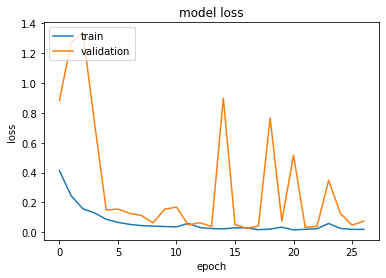

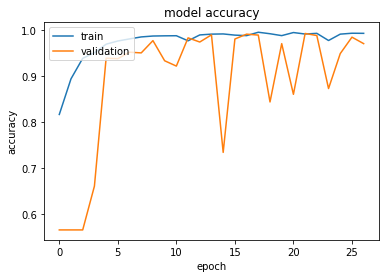

In [ ]:
# Loss plot
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Accuracy plot 
plt.plot(History.history['binary_accuracy'])
plt.plot(History.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluation 1 - Training data
scores_train = model.evaluate(training_set, steps=training_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_train[1], 3))

145/145 [==============================] - 34s 232ms/step - loss: 0.0199 - binary_accuracy: 0.9953
Accuracy:  0.995


In [ ]:
# Evaluation 2 - Validataion data
scores_val = model.evaluate(val_set, steps=val_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_val[1], 3))

62/62 [==============================] - 14s 231ms/step - loss: 0.0314 - binary_accuracy: 0.9929
Accuracy:  0.993


In [ ]:
# Evaluation 3 - Testing data
scores_test = model.evaluate(test_set, steps=test_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_test[1], 3))

22/22 [==============================] - 398s 19s/step - loss: 0.0102 - binary_accuracy: 0.9972
Accuracy:  0.997


In [ ]:
# Evaluation - Overview
eval_df = np.array(
            [
              [round(scores_train[1], 3), round(scores_val[1], 3), round(scores_test[1], 3)]
            ]
          )

eval_df = pd.DataFrame(eval_df, columns=['Train', 'Validation', 'Test'])
rowname = np.array(['Accuracy'])
eval_df.index = rowname
eval_df

,Train,Validation,Test
Accuracy,0.995,0.993,0.997


In [ ]:
# Evaluation - Confusion Matrix Part 1
pred_probs = model.predict_generator(test_set, verbose=1)
predictions = pred_probs > 0.5
predictions = np.squeeze(predictions, axis=-1).astype("int32")
true = test_set.classes

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


23/23 [==============================] - 3s 127ms/step


In [ ]:
# Evaluation - Confusion Matrix Part 2
confusion_matrix(true, predictions)

array([[260,   2],
       [  0, 453]])

In [ ]:
# Evaluation - Confusion Matrix Part 3
print(classification_report(true, predictions, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.992     0.996       262
           1      0.996     1.000     0.998       453

    accuracy                          0.997       715
   macro avg      0.998     0.996     0.997       715
weighted avg      0.997     0.997     0.997       715



In [ ]:
# Evaluation - AUC & ROC Part 1
test_auc = roc_auc_score(true, pred_probs)
true_probs = [0 for _ in range(len(true))]

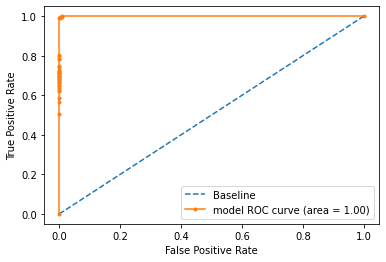

In [ ]:
# Evaluation - AUC & ROC Part 2

# calculate roc curves
true_fpr, true_tpr, _ = roc_curve(true, true_probs)
pred_fpr, pred_tpr, _ = roc_curve(true, pred_probs)

# plot the roc curve for the model
pyplot.plot(true_fpr, true_tpr, linestyle='--', label='Baseline')
pyplot.plot(pred_fpr, pred_tpr, marker='.', label='model ROC curve (area = %0.2f)' % test_auc)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(loc="lower right")
# show the plot
pyplot.show()